In [22]:
# Pytorch tools
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
from torch.utils.data import sampler

# For plotting
import matplotlib.pyplot as plt
import numpy as np
import time


In [137]:
def data_loader(batch_size):
    """
    Given a batch size, generate loaders

    Args:
        batch_size: int representing number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
    """
    transform_data = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    #Load the entire dataset
    #full_dataset = datasets.ImageFolder(root = 'Kaggle_Data/Alzheimer_Data', transform=transform_data)
    #full_dataset = datasets.ImageFolder(root = 'Alzheimer_s_Dataset', transform=transform_data)

    # Load the entire dataset
    full_dataset = datasets.ImageFolder(root='Kaggle_Data/Alzheimer_Data', transform=transform_data)

    # Determine the fraction of the dataset to use
    fraction = 1 / 15
    fraction_size = int(len(full_dataset) * fraction)

    # Take a subset of the full dataset
    subset_dataset, _ = t.utils.data.random_split(full_dataset, [fraction_size, len(full_dataset) - fraction_size])

    # Split the subset into training, validation, and testing
    train_size = int(0.7 * fraction_size)
    val_size = int(0.15 * fraction_size)
    test_size = fraction_size - train_size - val_size

    # Assign sizes to each subset
    train_dataset, val_dataset, test_dataset = t.utils.data.random_split(
        subset_dataset, [train_size, val_size, test_size]
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader
"""
    #Define a list of indices for the entire dataset
    indices = list(range(len(full_dataset)//15))
    np.random.shuffle(indices)

    #Define sizes of data split 70-15-15 training, validation, testing
    test_size = int(0.15*len(full_dataset)//15)
    valid_size = int(0.15*len(full_dataset)//15)
    train_size = int(len(full_dataset)//15 - test_size - valid_size)

    print(train_size)
    print(test_size)
    print(valid_size)

    #Indices for each data subset
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:valid_size+train_size]
    test_indices = indices[train_size+valid_size:train_size+valid_size+test_size]

    # Fetch samples based on indices
    train_sampler = sampler.SubsetRandomSampler(train_indices)
    valid_sampler = sampler.SubsetRandomSampler(valid_indices)
    test_sampler = sampler.SubsetRandomSampler(test_indices)
    
    # Create dataloaders from samples
    train_loader = DataLoader(full_dataset, batch_size, sampler = train_sampler)
    valid_loader = DataLoader(full_dataset,batch_size, sampler = valid_sampler)
    test_loader = DataLoader(full_dataset,batch_size, sampler = test_sampler)


    return train_loader, valid_loader, test_loader"""

def get_model_name(batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_epochs/densenetmodel_bs{0}_lr{1}_epoch{2}".format(
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader):
        #Input and labels
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        #Compute if the output matches the label
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


In [67]:
#Define classifier neural network
class classifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(classifier, self).__init__()
        self.name = "classifier"
        self.fc1 = nn.Linear(num_features, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1)
        return x

In [131]:
def train(net, batch_size = 32, learning_rate = 0.01, num_epochs = 10):

    #Load data
    train_loader, valid_loader, test_loader = data_loader(batch_size)

    # Freeze the weights for training
    for params in net.parameters():
        params.requires_grad = False

    #Attaching classifier to the pretrained model
    num_features = net.classifier.in_features
    custom_classifier = classifier(num_features, 1)
    net.classifier = custom_classifier
    
    criterion = nn.BCEWithLogitsLoss() #For binary classification
    optimizer = optim.SGD(net.parameters(), learning_rate, momentum = 0.9)
    
    train_error = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    valid_error = np.zeros(num_epochs)
    valid_loss = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_error = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader):

            #Input and labels
            inputs, labels = data
            #print(labels)
            
            #Zero the parameter gradients
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward() #Backward pass
            optimizer.step() #Update parameters
            
            #Compute if the output matches the label
            corr = (outputs > 0.0).squeeze().long() != labels

            #Stats
            total_train_error += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)

        #Training error and loss
        train_error[epoch] = float(total_train_error) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        #Run validation tests
        valid_error[epoch], valid_loss[epoch] = evaluate(net, valid_loader, criterion)
        #Print results
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_error[epoch],
                   train_loss[epoch],
                   valid_error[epoch],
                   valid_loss[epoch]))
        model_path = get_model_name(batch_size, learning_rate, epoch)
    t.save(net.state_dict(), model_path)
    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_error)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), valid_error)
    np.savetxt("{}_val_loss.csv".format(model_path), valid_loss)
        
        

In [ ]:
#To import trained model
import torchvision.models as models

#Initialize pretrained DenseNET-169 pretrained model
densenet169 = models.densenet169(models.DenseNet169_Weights)

#First Iteration
batch_size = 16
learning_rate = 0.01
epoch = 10

train(densenet169, batch_size=batch_size, learning_rate=learning_rate,num_epochs=epoch)
model_path = get_model_name(batch_size=batch_size, learning_rate=learning_rate, epoch=epoch-1)
plot_training_curve(model_path)


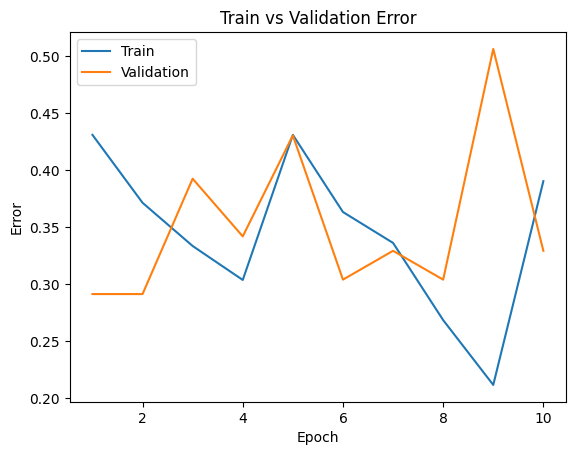

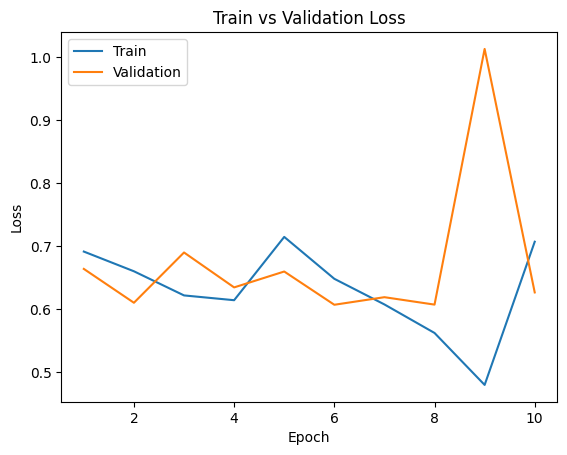

In [139]:
model_path = get_model_name(batch_size=batch_size, learning_rate=learning_rate, epoch=epoch-1)
plot_training_curve(model_path)
